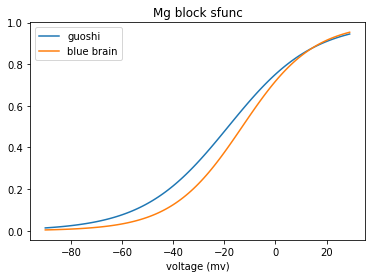

/content/NMDA_single_cell


0

In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
import os
%matplotlib inline

v = np.arange(-90,30,1)
temp = []
for i in range(len(v)):
    sfunc = 1/(1+(0.33*math.exp(-0.06*v[i]))) #function from mod file same as Guoshi's paper
    temp.append(sfunc)
    
temp2 = []
for i in range(len(v)):
    BB_sfunc = 1/(1+math.exp(0.07207477*-v[i])*(1/2.5522415))
    temp2.append(BB_sfunc)

plt.title("Mg block sfunc")
plt.plot(v,temp,label='guoshi')
plt.plot(v,temp2,label='blue brain')
plt.legend()
plt.xlabel('voltage (mv)')
plt.show()

RunningInCOLAB = 'google.colab' in str(get_ipython())
if RunningInCOLAB:
    !pip install ipywidgets==7.7.1 &> /dev/null
    !pip install neuron==8.0.0 &> /dev/null
    !git clone https://github.com/GregGlickert/NMDA_single_cell.git &> /dev/null 
    %cd NMDA_single_cell
os.system('nrnivmodl') # compile modfiles. Return 0 for success, 1 for failure.

BB stands for blue brain projects model


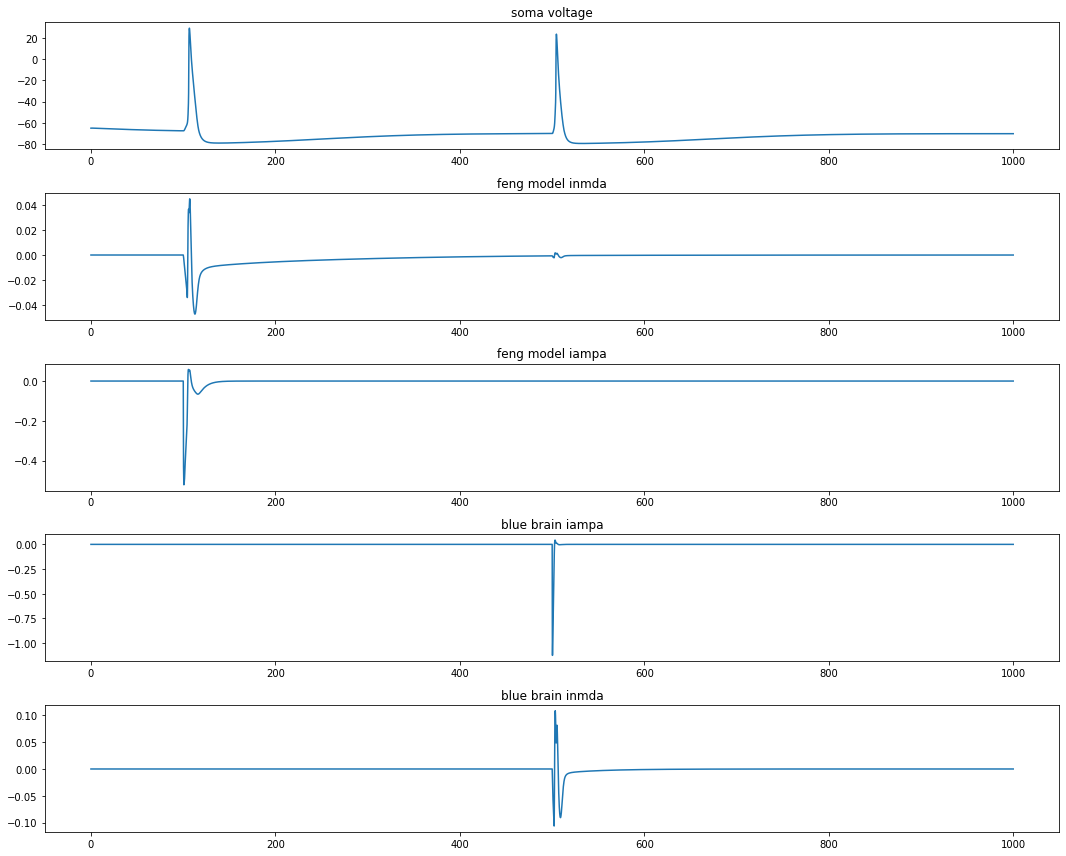

In [2]:
from neuron import h
from neuron.units import ms, mV
import matplotlib.pyplot as plt
from matplotlib import gridspec
import ipywidgets as widgets
from ipywidgets import interactive_output,HBox,VBox,Label,Layout
from IPython.display import display
from IPython.display import clear_output
import os
%matplotlib inline

def model(tstop,ourWeight,blueBrainWeight,ourStart,blueBrainStart):
    h.load_file('stdrun.hoc')
    h.load_file('PN_cells.hoc') # reads in template
    #h.nrn_load_dll('x86_64/.libs/libnrnmech.so')
    cell = h.PN_A()
    #cell = h.InterneuronCellf()
    h.dt = 0.1 # time step (resolution) of the simulation in ms
    h.tstop = tstop # how long to run the simulation in ms
    h.v_init= -65 # initial membrane potential in mV

    t = h.Vector()      # Vectors are used to record data in the simulation
    soma_v = h.Vector()
    i_nmda_1 = h.Vector()
    i_ampa_1 = h.Vector()
    i_nmda_2 = h.Vector()
    i_ampa_2 = h.Vector()

    conn1 = h.pyr2pyr(cell.dend[0](0.9)) # makes a syn connected to soma

    t.record(h._ref_t) # derefences and records data
    soma_v.record(cell.soma[0](0.5)._ref_v)
    i_nmda_1.record(conn1._ref_inmda)
    i_ampa_1.record(conn1._ref_iampa)


    #iclamp = h.IClamp(cell.dend[0](0.5)) # current injection
    #iclamp.delay = 10050 #long enought delay turns off iclamp easy
    #iclamp.dur = 200
    #iclamp.amp = 0.3

    conn1.initW = ourWeight #synaptic weight for pyr2pyr(our synapse)
    nstim_pyr2pyr= h.NetStim(0.9)

    nstim_pyr2pyr.interval=4000 #pyrpyr synapse 
    nstim_pyr2pyr.start=ourStart
    nstim_pyr2pyr.number = 100
    nstim_pyr2pyr.noise = 0 
    nc_pyr2pyr = h.NetCon(nstim_pyr2pyr,conn1,0,0,1)

    conn2 = h.ProbAMPANMDA_EMS_optimized(cell.dend[0](0.9)) #blue brain project synapse 

    t.record(h._ref_t) # derefences and records data
    soma_v.record(cell.soma[0](0.5)._ref_v)
    i_nmda_2.record(conn2._ref_i_NMDA)
    i_ampa_2.record(conn2._ref_i_AMPA)

    #conn.weight = 0.001 #synaptic weight
    nstim_AMPANMDA_EMS= h.NetStim(0.9)

    nstim_AMPANMDA_EMS.interval=4000 #blue brain project synapse 
    nstim_AMPANMDA_EMS.start=blueBrainStart
    nstim_AMPANMDA_EMS.number = 100
    nstim_AMPANMDA_EMS.noise = 0 
    nc_AMPANMDA = h.NetCon(nstim_AMPANMDA_EMS,conn2,0,0,blueBrainWeight) #change this number to change syn weight currently it 1 

    h.finitialize(-65 * mV)
    h.continuerun(h.tstop * ms)
    
    plot(t,soma_v,i_ampa_1,i_ampa_2,i_nmda_1,i_nmda_2)

def plot(t,soma_v,i_ampa_1,i_ampa_2,i_nmda_1,i_nmda_2):
    fig = plt.figure(figsize=(15, 12),tight_layout=True) 
    gs = gridspec.GridSpec(5, 1, width_ratios=[1],height_ratios=[1,1,1,1,1]) 


    ax0 = plt.subplot(gs[0,0])
    ax1 = plt.subplot(gs[1,0])
    ax2 = plt.subplot(gs[2,0])
    ax3 = plt.subplot(gs[3,0])
    ax4 = plt.subplot(gs[4,0])
    ax0.plot(t ,soma_v)
    ax0.set_title('soma voltage')

    ax1.plot(t ,i_nmda_1)
    ax1.set_title('feng model inmda')

    ax2.plot(t,i_ampa_1)
    ax2.set_title('feng model iampa')

    ax3.plot(t,i_ampa_2)
    ax3.set_title('blue brain iampa')

    ax4.plot(t,i_nmda_2)
    ax4.set_title('blue brain inmda')
    plt.show()


tstop = 1000
ourWeight = 10
blueBrainWeight = 20
ourStart = 100
blueBrainStart = 500

w_run = widgets.Button(description='Run',icon='history',button_style='primary')
w_tstop = widgets.FloatSlider(value=tstop,min=100,max=2000, step=100,description='Tstop (ms)')
w_ourWeight = widgets.FloatSlider(value=ourWeight,min=0,max=30, step=0.5,description='feng Weight')
w_blueBrainWeight = widgets.FloatSlider(value=blueBrainWeight,min=0,max=30, step=0.5,description='BB Weight')
w_ourStart = widgets.FloatSlider(value=ourStart,min=100,max=2000, step=100,description='feng Start')
w_blueBrainStart = widgets.FloatSlider(value=blueBrainStart,min=100,max=2000, step=10,description='BB Start')
print("BB stands for blue brain projects model")
def run_model(*arges):
    clear_output()
    tstop = w_tstop.value
    ourWeight = w_ourWeight.value
    blueBrainWeight = w_blueBrainWeight.value
    ourStart = w_ourStart.value
    blueBrainStart = w_blueBrainStart.value
    print("BB stands for blue brain projects model")
    display(ui)
    model(tstop,ourWeight,blueBrainWeight,ourStart,blueBrainStart)
    
w_run.on_click(run_model)

ui = VBox([ w_run, w_tstop,HBox([w_ourWeight,w_blueBrainWeight]),HBox([w_ourStart,w_blueBrainStart])])
ui
    